In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import gurobipy          as     gp      # type: ignore
from   gurobipy          import GRB     # type: ignore
import pandas            as     pd      # type: ignore
import matplotlib.pyplot as     plt     # type: ignore
from   IPython.display   import display # type: ignore
import networkx          as     nx      # type: ignore

%matplotlib inline

In [2]:
# Supply from cities
supply = {
    'NewYork': 300000,
    'NewJersey': 400000
}

# Depot throughput limits
through = {
    'Bronx': 140000,
    'Brooklyn': 100000,
    'Queens': 200000,
    'StatenIsland': 80000
}

# Landfill demands
demand = {
    'C1': 100000,
    'C2': 20000,
    'C3': 80000,
    'C4': 70000,
    'C5': 120000,
    'C6': 40000,
    'C7': 50000,
    'C8': 50000,
    'C9': 50000  # New landfill for Variation 3
}
# Transportation costs
arcs, cost = gp.multidict({
    ('NewYork', 'Bronx'): 0.7,
    ('NewYork', 'Brooklyn'): 0.7,
    ('NewYork', 'Queens'): 1.2,
    ('NewYork', 'StatenIsland'): 0.4,
    ('NewYork', 'C1'): 1.2,
    ('NewYork', 'C3'): 1.7,
    ('NewYork', 'C4'): 2.2,
    ('NewYork', 'C6'): 1.2,
    ('NewYork', 'C7'): 2.0,
    ('NewYork', 'C8'): 2.1,
    ('NewYork', 'C9'): 2.3,  # new cost
    ('NewJersey', 'Brooklyn'): 0.5,
    ('NewJersey', 'Queens'): 0.7,
    ('NewJersey', 'StatenIsland'): 0.4,
    ('NewJersey', 'C1'): 2.2,
    ('NewJersey', 'C7'): 1.8,
    ('NewJersey', 'C8'): 1.9,
    ('NewJersey', 'C9'): 2.0,  # new cost
    ('Bronx', 'C2'): 1.7,
    ('Bronx', 'C3'): 0.7,
    ('Bronx', 'C4'): 1.7,
    ('Bronx', 'C6'): 1.2,
    ('Bronx', 'C7'): 1.9,
    ('Bronx', 'C8'): 2.0,
    ('Bronx', 'C9'): 2.1,  # new cost
    ('Brooklyn', 'C1'): 1.2,
    ('Brooklyn', 'C2'): 0.7,
    ('Brooklyn', 'C3'): 0.7,
    ('Brooklyn', 'C4'): 1.2,
    ('Brooklyn', 'C5'): 0.7,
    ('Brooklyn', 'C7'): 1.5,
    ('Brooklyn', 'C8'): 1.6,
    ('Brooklyn', 'C9'): 1.7,  # new cost
    ('Queens', 'C2'): 1.7,
    ('Queens', 'C3'): 2.2,
    ('Queens', 'C5'): 0.7,
    ('Queens', 'C6'): 1.7,
    ('Queens', 'C7'): 1.6,
    ('Queens', 'C8'): 1.5,
    ('Queens', 'C9'): 1.8,  # new cost
    ('StatenIsland', 'C3'): 0.4,
    ('StatenIsland', 'C4'): 1.7,
    ('StatenIsland', 'C5'): 0.7,
    ('StatenIsland', 'C6'): 1.7,
    ('StatenIsland', 'C7'): 2.1,
    ('StatenIsland', 'C8'): 2.0,
    ('StatenIsland', 'C9'): 2.2  # new cost
})

In [3]:
# Create optimization model
model = gp.Model('Landfill Transportation Var3')
# Create flow variables
flow = model.addVars(arcs, obj=cost, name="flow", vtype=GRB.CONTINUOUS)
# Supply limits
centers = supply.keys()
model.addConstrs((gp.quicksum(flow.select(center, '*')) <= supply[center] for center in centers), name="center")
# Landfill demand
landfills = demand.keys()
model.addConstrs((gp.quicksum(flow.select('*', landfill)) == demand[landfill] for landfill in landfills), name="landfill")
# Depot flow conservation
depots = through.keys()
model.addConstrs((gp.quicksum(flow.select(depot, '*')) == gp.quicksum(flow.select('*', depot)) for depot in depots), name="depot")
# Depot throughput limits
model.addConstrs((gp.quicksum(flow.select('*', depot)) <= through[depot] for depot in depots), name="depot_capacity")
# Solve the model
model.optimize()

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F5053j)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 19 rows, 47 columns and 101 nonzeros
Model fingerprint: 0x9096031f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+05]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 18 rows, 47 columns, 100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1700000e+05   5.500000e+04   0.000000e+00      0s
      13    8.2600000e+05   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.260000000e+05


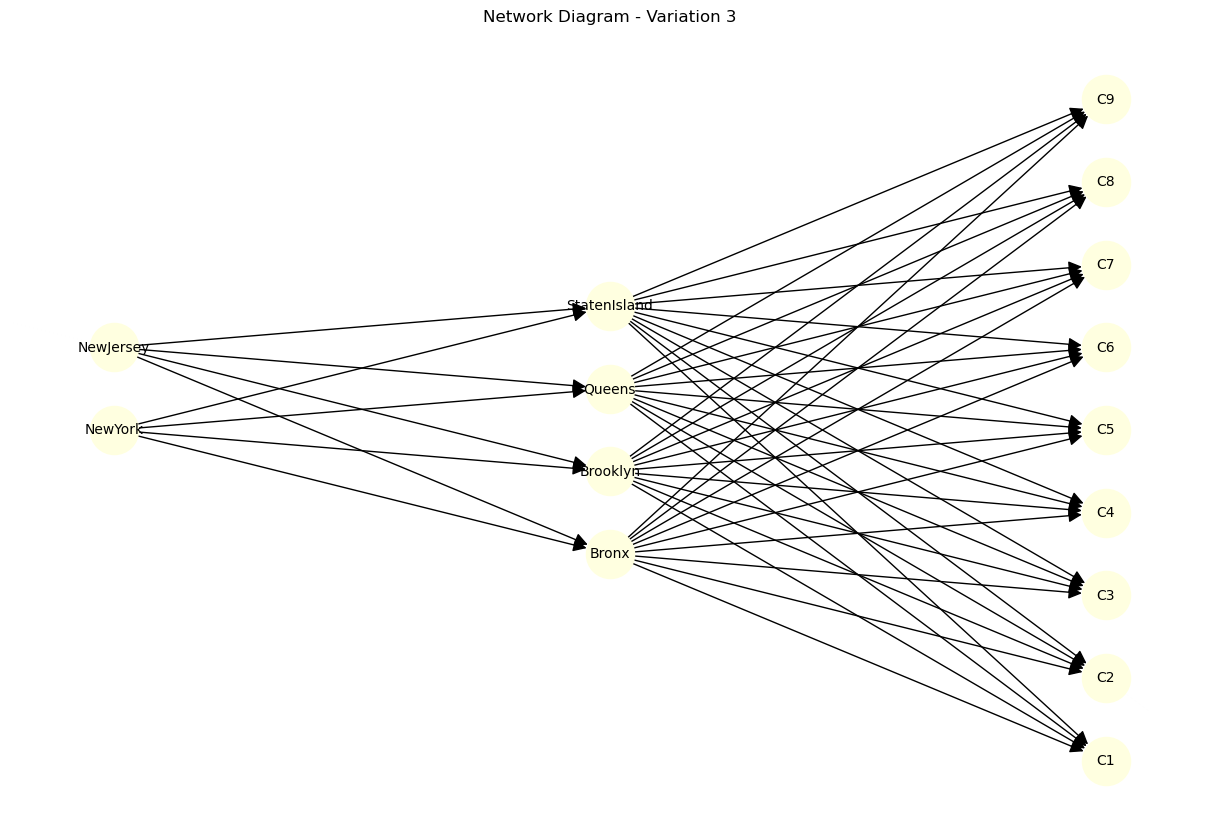

In [4]:
# Create directed graph
G = nx.DiGraph()
# Nodes
cities = ['NewYork', 'NewJersey']
depots = ['Bronx', 'Brooklyn', 'Queens', 'StatenIsland']
landfills = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
# Add nodes
G.add_nodes_from(cities)
G.add_nodes_from(depots)
G.add_nodes_from(landfills)
# Add edges
for city in cities:
    for depot in depots:
        G.add_edge(city, depot)
for depot in depots:
    for landfill in landfills:
        G.add_edge(depot, landfill)
# Define layout
pos = {}
# Cities on the left
for i, city in enumerate(cities):
    pos[city] = (-2, i)
# Depots in the center
for i, depot in enumerate(depots):
    pos[depot] = (0, i-1.5)
# Landfills on the right
for i, landfill in enumerate(landfills):
    pos[landfill] = (2, i-4)
# Draw
plt.figure(figsize=(12,8))
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=1200, arrowsize=20, font_size=10)
plt.title('Network Diagram - Variation 3')
plt.axis('off')
plt.show()

In [5]:
product_flow = pd.DataFrame(columns=["From", "To", "Flow"])
for arc in arcs:
    if flow[arc].x > 1e-6:
        # Create a new DataFrame for the current row
        new_row = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [flow[arc].x]})
        # Concatenate the new row with the existing DataFrame
        product_flow = pd.concat([product_flow, new_row], ignore_index=True)  
product_flow.index=[''] * len(product_flow)

In [6]:
totalCost = 0 
totalFlow = 0
product_cost = pd.DataFrame(columns=["From", "To", "cost", "Flow", "total"])
for arc in arcs:
    if flow[arc].x > 1e-6:
        totalCost = totalCost+ cost[arc] * flow[arc].X
        totalFlow = totalFlow + flow[arc].X
        # Create a new DataFrame for the current row
        new_row = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "cost": [cost[arc]], "Flow": [flow[arc].x], "total": [cost[arc] * flow[arc].x]})
        # Concatenate the new row with the existing DataFrame
        product_cost = pd.concat([product_cost, new_row], ignore_index=True)  
product_cost.index = [''] * len(product_cost)

In [7]:
print("Flow")
print("------------------------------------")
display(product_flow)

Flow
------------------------------------


,From,To,Flow
,NewYork,StatenIsland,40000.0
,NewYork,C1,100000.0
,NewYork,C6,40000.0
,NewJersey,Brooklyn,100000.0
,NewJersey,Queens,110000.0
,NewJersey,StatenIsland,40000.0
,NewJersey,C7,50000.0
,NewJersey,C8,50000.0
,NewJersey,C9,50000.0
,Brooklyn,C2,20000.0


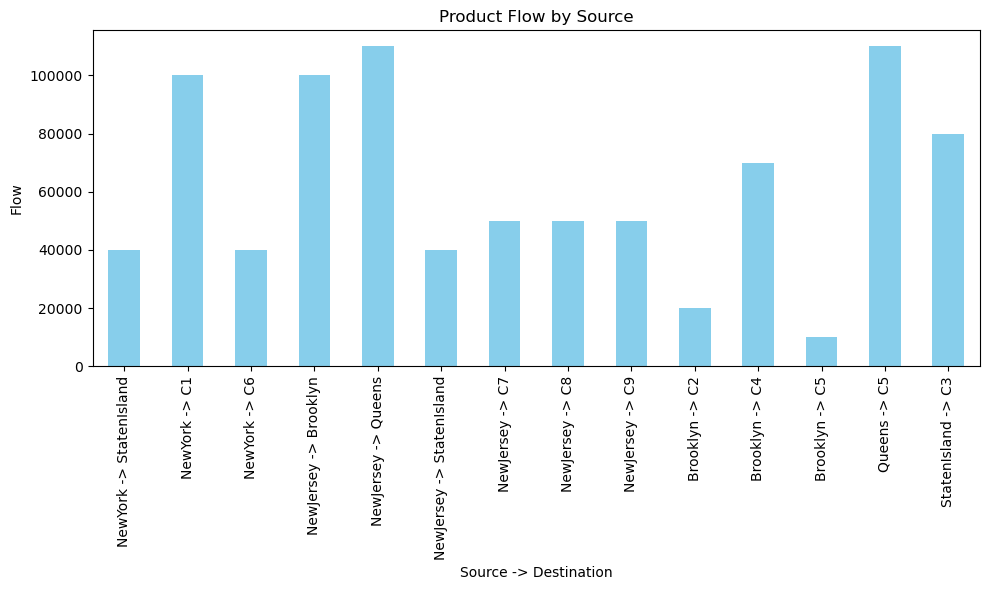

In [8]:
product_flow['From+To'] = product_flow['From'] + ' -> ' + product_flow['To']
product_flow.plot(kind='bar', x='From+To', y='Flow', figsize=(10, 6), legend=False, color='skyblue')
plt.title('Product Flow by Source')
plt.xlabel('Source -> Destination')
plt.ylabel('Flow')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
print("Cost")
print("---------------------------------------------------")
display(product_cost)

Cost
---------------------------------------------------


,From,To,cost,Flow,total
,NewYork,StatenIsland,0.4,40000.0,16000.0
,NewYork,C1,1.2,100000.0,120000.0
,NewYork,C6,1.2,40000.0,48000.0
,NewJersey,Brooklyn,0.5,100000.0,50000.0
,NewJersey,Queens,0.7,110000.0,77000.0
,NewJersey,StatenIsland,0.4,40000.0,16000.0
,NewJersey,C7,1.8,50000.0,90000.0
,NewJersey,C8,1.9,50000.0,95000.0
,NewJersey,C9,2.0,50000.0,100000.0
,Brooklyn,C2,0.7,20000.0,14000.0


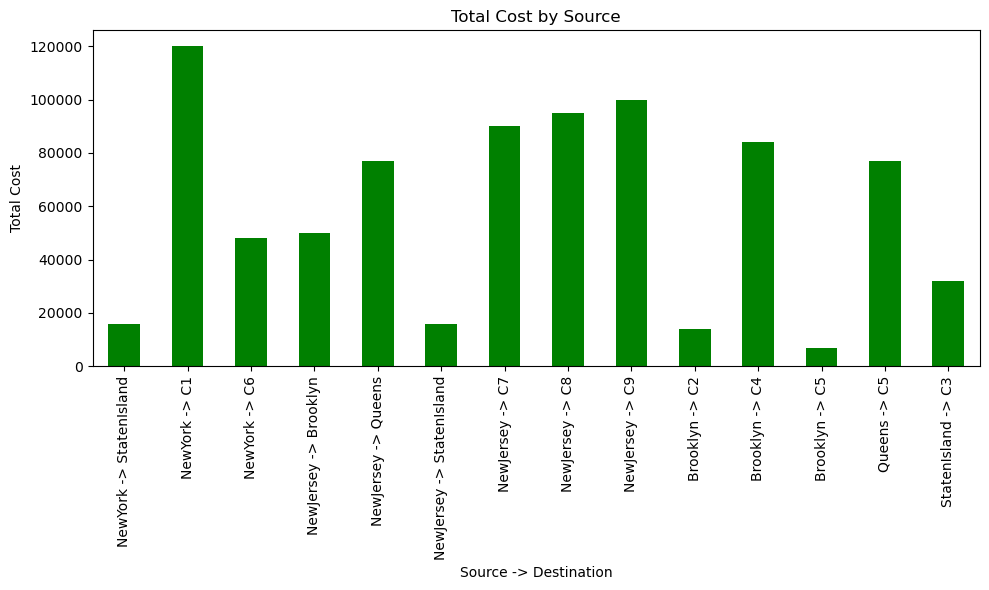

In [10]:
product_cost['From+To'] = product_cost['From'] + ' -> ' + product_cost['To']
product_cost.plot(kind='bar', x='From+To', y='total', figsize=(10, 6), legend=False, color='green')
plt.title('Total Cost by Source')
plt.xlabel('Source -> Destination')
plt.ylabel('Total Cost')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
print(f"The total Flow is: {totalFlow:,.2f}")
print(f"The total Cost is: {totalCost:,.2f}")

The total Flow is: 870,000.00
The total Cost is: 826,000.00
